### Week 2 Homework: Stock Prediction
The homework for this week is to build 3 different types of regression lines to predict stock prices using Python, then print out the prediction for the best performing one.
The work below is largely based on this article:<br/>
[Build a Stock Prediction Algorithm](https://enlight.nyc/projects/stock-market-prediction/)

To identify "best prediction", I use Mean Squared Error between predicted and actual values.
    
### I' now convinced this is overfit.  It cannot be thatfor  every stock I give it  correctly prdicts <em>every market turn.</em>  Further analysis required.

#### What I learned
+ I took too long to do this assignment.  Why?  
  + *I did not successfully search GitHub!*  I tried to follow the article and discovered that it had missing steps.  I clicked on the GitHub link, but it was broken.  I found a different article, but it had its own challenges.  **I should have instead  searched GitHub for the author's name - I would have found the working example of the code from recommended  article.**  
  + I did not understand that the package I wanted to use had been deprecated.  When a package I want won't load, I need see if the package has been replaced by one with a new name.
  + I did not understand that Conda & Pip can have different names for the same package (e.g. sklearn (pip) and scikit-learn (conda))
+ There is value in the feature engineering done in the suggested article.  This implementation has only closing prices, where the other has closing prices and 2 features calculate from additional data.  The confidence values are consistently higher than those I achieve.  More data = better predictions.
+ This technology will be key to one of the two projects I have planned to pursue after this course!  The initial test of the linear regression model correctly predicted a 50% drop in the price of a stock I bought a month ago.  That would have been nice to know about in advance!
+ Different stocks have very different results.  While NKTR's 50% drop is correctly forecast, AMZN comes back with some forecast prices as negative.  


### Follow-on work
+ Show prediction from current data forward
+ Do this again with the originally recommended code.  Review the features he engineered and compare performance.
+ Simple web site that allows entry of a stock ticker (and maybe a forecast period?), runs the models, shows graphs the result.
+ Mean Squared Error can't be used to compare fit between different stocks, since it will scale with the price of the stock.  Consider using [Mean Absolute Percentage Error](https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn/62511#62511) so that the performance of the fit for a given algorithm between stocks can be considered.
+ Is the performance of the algorithm over the last period a reliable indicator of how it will perform over the next period?
+ The shape of the curve seems "too good".  Did I somehow include the data I am predicting in my trainig data?  Need to investigate this.
+ Get a big pink error when preping the data to plot... sometimes?  Need to better understand DataFrames




In [1]:
# parameters
# set the ticker we are after
ticker = "nktr" # Try AMZN for Poly fit; NKTR for Linear fit

# set how long our forcasting period is
forecast_out = 90

# set end date of data frame
end_date_string = "2018-12-30" # values are "today or date string formatted YYYY-MM-DD"

In [2]:
#imports
import datetime
import pandas as pd
import numpy as np

from sklearn import preprocessing, svm

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split # This was the primary edit - sklearn.cross_validation is retired

from sklearn.metrics import mean_squared_error

from yfinance import Ticker

In [3]:
#fetch our stock data

# do some date math to get start & end dates for our stock dataset
end_date = datetime.date.today()
if end_date_string != "today":
    end_date = datetime.datetime.strptime(end_date_string, '%Y-%m-%d') #test for this years dump in january


fetch_size = datetime.timedelta(days=3650+forecast_out) #10 years, give or take, + our forecasting window, that will be cut off
start_date = end_date - fetch_size
start_str = start_date.strftime("%Y-%m-%d")
end_str = end_date.strftime("%Y-%m-%d")

#get the data
stock = Ticker(ticker)

I note a usage pattern, where a dataframe is modified and set back to itself.  
My first reaction is to hate this, as we loose the previous state of the table if we want to debug.

On the other hand, it does keep you from have a lot of copies of this data
lying around, which I suppose is a good thing.  Let's try that here.

In [4]:
#grab our data
raw_stock_df = stock.history(start=start_str, end=end_str)  #to consider: what kind of errors can occur?  how to handle?

#let's have a look...
display(raw_stock_df)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2008-10-03,3.600000,3.670000,3.450000,3.460000,701100,0.0,0
2008-10-06,3.370000,3.460000,3.180000,3.350000,1266200,0.0,0
2008-10-07,3.550000,3.550000,3.180000,3.270000,819200,0.0,0
2008-10-08,3.540000,3.540000,3.140000,3.230000,892600,0.0,0
2008-10-09,3.290000,3.540000,2.840000,2.910000,845900,0.0,0
...,...,...,...,...,...,...,...
2018-12-21,32.310001,33.000000,30.320000,30.620001,4490100,0.0,0
2018-12-24,30.000000,30.950001,29.219999,30.430000,1170200,0.0,0
2018-12-26,30.770000,32.820000,30.049999,32.779999,1618600,0.0,0


In [5]:
# strip to just the closes
df = raw_stock_df.loc[:,['Close']]  #need tobetter understand what this does 
df_actuals = df.tail(forecast_out)  #save these to actuals to compare to predictions when we have some
actuals = np.array(df_actuals)


#create the label (prediction) to which we are training
df['Prediction'] = df['Close'].shift(-forecast_out) 

display(df) #to show the NaN's

,Close,Prediction
Date,,
2008-10-03,3.460000,5.05
2008-10-06,3.350000,4.93
2008-10-07,3.270000,4.70
2008-10-08,3.230000,4.80
2008-10-09,2.910000,4.71
...,...,...
2018-12-21,30.620001,NaN
2018-12-24,30.430000,NaN
2018-12-26,32.779999,NaN


In [6]:
# now we need to prepare the data for training...

#for the input values, that will be data we just created, minus the label
X = np.array(df.drop(['Prediction'], 1))  #drop "Prediction" from dataframe, then convert to array
X = preprocessing.scale(X)                #scale the inputs for analysis

X_forecast = X[-forecast_out:]            # set X_forecast to last *forecast_out* items
X = X[:-forecast_out]                     # and set X to everthing BUT the last *forecast_out* items

#now the outputs
y = np.array(df['Prediction'])           # which is *just* Prediction
y = y[:-forecast_out]                    # and everthing but the forecast window

### Linear Regression
Finally, prediction time! First, we’ll want to split our testing and training data sets, and set our test_size equal to 20% of the data. The training set contains our known outputs, or prices, that our model learns on, and our test dataset is to test our model’s predictions based on what it learned from the training set.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [8]:
# Training & Predict - Model 1
clf = LinearRegression()
clf.fit(X_train,y_train)
# Testing
confidence_linReg = clf.score(X_test, y_test)
print("confidence: ",  confidence_linReg)
# Forecast
forecast_prediction_linReg = clf.predict(X_forecast)
mse_linReg = mean_squared_error(actuals, forecast_prediction_linReg)
#display(forecast_prediction_linReg)
print("mean squared error actual vs. predicted: ", mse_linReg)



confidence:  0.5450792170516832
mean squared error actual vs. predicted:  46.67320054471985


In [9]:
# Training & Predict - Model 2 : Quadratic Regression
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)
# Testing
confidence_clfpoly2 = clfpoly2.score(X_test, y_test)
print("confidence: ",  confidence_clfpoly2)
# Forecast
forecast_prediction_clfpoly2 = clfpoly2.predict(X_forecast)
mse_clfpoly2 = mean_squared_error(actuals, forecast_prediction_clfpoly2)
#display(forecast_prediction_linReg)
print("mean squared error actual vs. predicted: ", mse_clfpoly2)

confidence:  0.6199383863874499
mean squared error actual vs. predicted:  138.39734316580183


In [10]:
# Training & Predict - Model 3 : Third Order Polynomial Regression
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
# Testing
confidence_clfpoly3 = clfpoly3.score(X_test, y_test)
print("confidence: ",  confidence_clfpoly3)
# Forecast
forecast_prediction_clfpoly3 = clfpoly3.predict(X_forecast)
mse_clfpoly3 = mean_squared_error(actuals, forecast_prediction_clfpoly3)
#display(forecast_prediction_linReg)
print("mean squared error actual vs. predicted: ", mse_clfpoly3)

confidence:  0.6198649566254792
mean squared error actual vs. predicted:  137.69812011228152


In [11]:
results = {
    mse_linReg   : ("Linear Regression", forecast_prediction_linReg),
    mse_clfpoly2 : ("2nd Order Polynomial Regression",forecast_prediction_clfpoly2),
    mse_clfpoly3 : ("3rd Order Polynomial Regression",forecast_prediction_clfpoly3)
}
best = results[min(results.keys())] # the "best" result is the one with them min(mean squared error)


In [12]:
# plot actual vs prediction for best fitting algorithm
last_thirty = raw_stock_df.tail(forecast_out)
best_name, best_data = best
best_name = str(best_name)  #This is interesting.  If I don't conver this to a string, it kinda blows up... 
                            #maybe this had no impact...???  To be Investigated

last_thirty.loc[:,best_name] = best_data                #add in the predicted data #THIS is causing red warning below
last_thirty = last_thirty.loc[:, ['Close', best_name]]  # trim to only the colunns about which I care
#last_thirty

C:\Users\mhsco\Anaconda3\envs\week-2\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\mhsco\Anaconda3\envs\week-2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


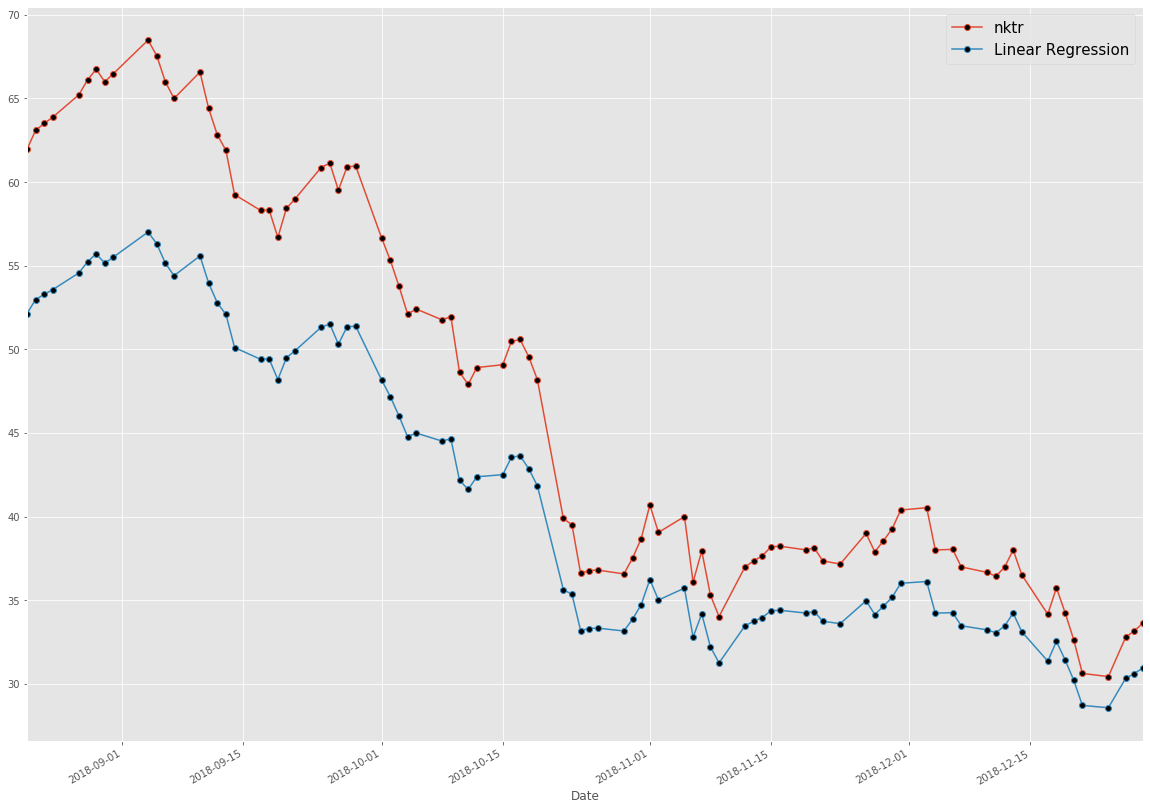

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(20,15))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')
last_thirty["Close"].plot(label=ticker,style='.-',  marker='o', markerfacecolor='black')
last_thirty[best_name].plot(label=best_name, style='.-',  marker='o', markerfacecolor='black')
plt.legend(prop={'size' : 15})

,nktr
Date,
2018-08-21,61.959999
2018-08-22,63.090000
2018-08-23,63.509998
2018-08-24,63.889999
2018-08-27,65.220001
...,...
2018-12-21,30.620001
2018-12-24,30.430000
2018-12-26,32.779999


,nktr,Linear Regression (best),2nd Order Polynomial Regression,3rd Order Polynomial Regression
Date,,,,
2018-08-21,61.959999,52.132472,67.084548,66.763986
2018-08-22,63.090000,52.977045,67.310926,66.978231
2018-08-23,63.509998,53.290955,67.384469,67.047518
2018-08-24,63.889999,53.574971,67.446059,67.105382
2018-08-27,65.220001,54.569026,67.624599,67.271853
...,...,...,...,...
2018-12-21,30.620001,28.708685,44.239980,44.354656
2018-12-24,30.430000,28.566677,44.003958,44.120104
2018-12-26,32.779999,30.323086,46.840530,46.936180


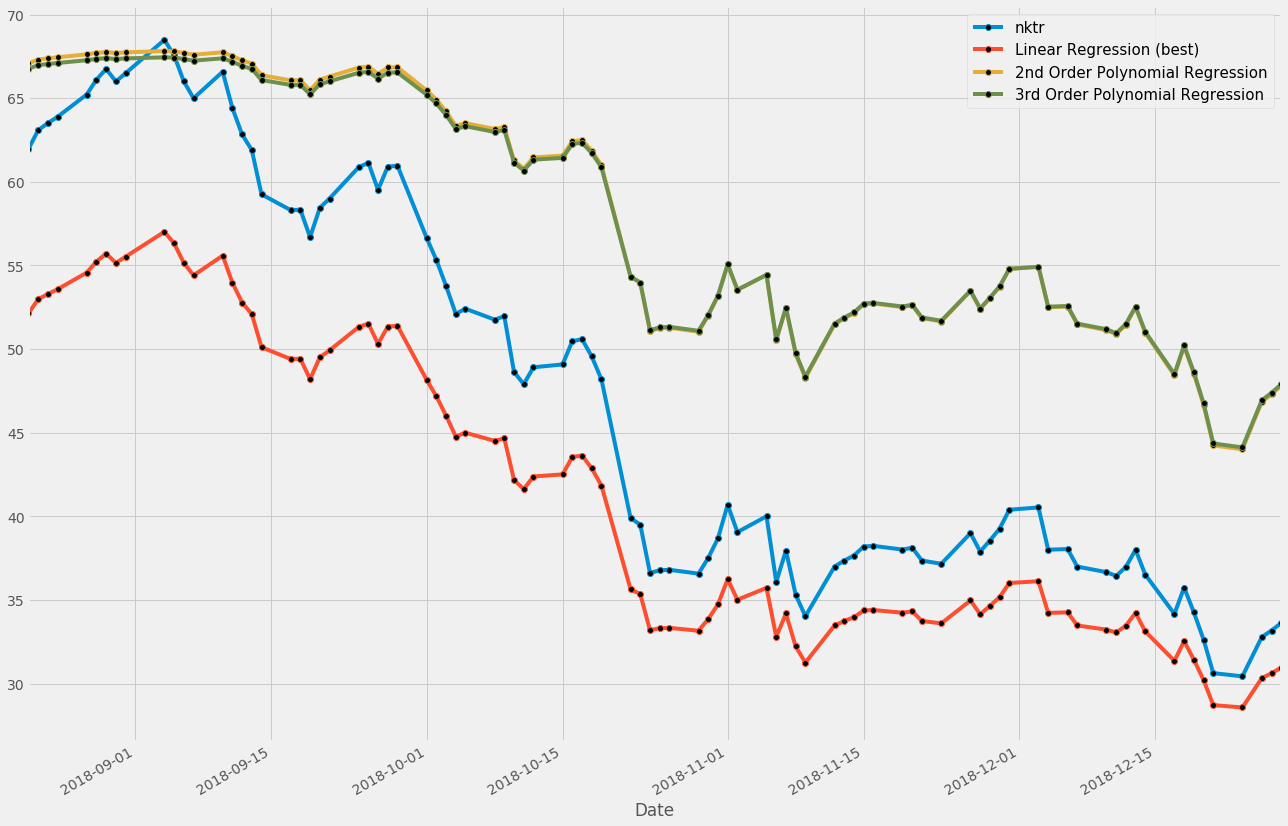

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(20,15))
mpl.__version__

# Adjusting the style of matplotlib
style.use('fivethirtyeight')

pred_df = raw_stock_df.tail(forecast_out)
pred_df = pred_df.loc[:,['Close']]  #need tobetter understand what this does 
pred_df.columns = [ticker]
display(pred_df)
for model in results: 
    reg_name, reg_result = results[model]
    legend_label = reg_name
    if (best_name == reg_name):
        legend_label = legend_label + " (best)"

   # display(len(reg_result))
   # display(pred_df.size)
    pred_df.loc[:,legend_label] = reg_result                #add in the predicted data #THIS is causing red warning below
    
display( pred_df)    

pred_df.plot(style='.-',  marker='o', markerfacecolor='black')                    # and plot that
plt.legend(prop={'size' : 15})        
